# Modules, functions

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

Loading BokehJS ...

In [2]:
# CHRIS and ARTEM code

def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m

    return loglik_res

# ----------------------------------------------------------------

def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) 
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m

    return loglik_res

# ----------------------------------------------------------------

def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS_2(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

# Data

## ----- Buyer reference data (by season) -----

In [3]:
buyer_table = pd.read_csv('data/EU_seasons.csv', low_memory = False, error_bad_lines = False, sep = ",") # 26 Aug
buyer_table = buyer_table[(buyer_table.season == 'FW19')]

## ---- adi & rbk ----

In [4]:
# ----- adidas ------ 

# rma1_adi = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",", usecols = ['Article Number', 'Market Retail Price', 'WE eCom', 'eCom Range']) # (13618, 4)

rma2_adi = pd.read_excel('data/RMA-02_ Market Range Plan_24102019.xlsx', sheet_name='BSO', skiprows=2) # adidas RMA2 -- 21 October

rma2_adi = rma2_adi[['Article Number', 'Sum of WE eCom', 'Market Retail Price']]

rma2_adi = rma2_adi[rma2_adi['Sum of WE eCom'] != 0]

In [5]:
# ----- rbk ------ 

# rma1_rbk = pd.read_csv('data/article_range_rma1_reebok_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",", usecols = ['Article_number', 'Total Marketing Forecast', '  Total Net Sales  ', '  Total Inline Forecast  ']) # rma1_rbk.columns[40:]

rma2_rbk = pd.read_excel('data/eCom Range Download_Reebok_FW20.xlsx') # Reebok RMA2 - 21 October
rma2_rbk = rma2_rbk[['Article Number', 'RBK WE eCom', 'Hub Retail Price']]

clssc_rbk = pd.read_csv('data/reebok_classics.csv') # Reebok RMA2 - 21 October

addtl_classics = (
    set(clssc_rbk.article_number).
    symmetric_difference(rma2_rbk['Article Number']).
    intersection(clssc_rbk.article_number)
                 )

In [6]:
carryovers = (set(buyer_table.article_number).
              intersection(set(rma2_adi['Article Number'])).
              union(set(buyer_table.article_number).
                    intersection(set(rma2_rbk['Article Number'])))
             )
print('Carryovers: ', len(carryovers))
print()

print('adi carryovers: ', len(set(buyer_table.article_number).intersection(set(rma2_adi['Article Number']))))
print('rbk carryovers: ', len(set(buyer_table.article_number).intersection(set(rma2_rbk['Article Number']))))


Carryovers:  991

adi carryovers:  883
rbk carryovers:  108


In [7]:
rma2_adi['rev'] = rma2_adi['Sum of WE eCom'] * rma2_adi['Market Retail Price']

rma2_adi['carryover'] = rma2_adi['Article Number'].isin(carryovers)

print('Total range: ', len(rma2_adi['Article Number'].unique()))
rma2_adi.head()
rma2_adi.carryover.value_counts() # non/carryover

# Revenue total
rma2_adi.rev.sum()
rma2_adi.groupby('carryover')['rev'].sum().round()

Total range:  7890


,Article Number,Sum of WE eCom,Market Retail Price,rev,carryover
0,011040,290,149.95,43485.50,True
1,015110,435,149.95,65228.25,True
2,019000,3000,74.95,224850.00,True
3,019228,290,129.95,37685.50,True
4,019310,700,129.95,90965.00,True


False    7007
True      883
Name: carryover, dtype: int64

606680151.75

carryover
False    499059946.0
True     107620205.0
Name: rev, dtype: float64

In [8]:
rbk_carryovers = carryovers.union(addtl_classics)

In [ ]:
rma2_rbk['rev'] = rma2_rbk['RBK WE eCom'] * rma2_rbk['Hub Retail Price']

In [ ]:
rma2_rbk['carryover'] = rma2_rbk['Article Number'].isin(rbk_carryovers)

In [ ]:
len(rma2_rbk['Article Number'].unique())
rma2_rbk.head()
rma2_rbk.carryover.value_counts() # non/carryover

# Revenue total
rma2_rbk.rev.sum()
rma2_rbk.groupby('carryover')['rev'].sum().round()

## ----- carryovers -----

In [ ]:
# rma1_adi = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",")
                       
# rma1_adi[rma1_adi['Article Number'].isin(missings)]
                       
                       

In [9]:
dat0 = pd.read_csv('data/ch4k_df.csv')
ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                  'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc',
                                  'brand_desc', 'bus_unit_desc', 'rmh_cat_desc'])

In [10]:
# Remove clearance transactions!!

dat0['clearance'] = dat0.clearance.fillna(0) 

dat0['net_qty'] = (1 - dat0.clearance)*dat0.net_qty

# GAS

In [11]:
dat_GAS = dat0.copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'buy_availability']]

dat_GAS = dat_GAS[(dat_GAS.season == 'FW19') & (dat_GAS.article_number.isin(carryovers))].sort_values(['article_number', 'country', 'year', 'week'])


In [12]:
# dat_GAS_a = np.random.choice(dat_GAS.article_number.unique(), size = 100, replace = False)
# dat_GAS = dat_GAS[dat_GAS.article_number.isin(dat_GAS_a)]

dat_GAS = dat_GAS.groupby(['article_number', 'country']).apply(GAS_est).reset_index()

In [13]:
dat_GAS = pd.DataFrame(dat_GAS.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()


# Seasonality

In [14]:
seasonality_dat = (dat0.
    copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 
            'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 
            'age_group_desc', 'franchise', 'prod_grp_desc']].
    dropna().sort_values(['article_number', 'year', 'week'])
                  )

# -- Sum over UK/EU, ADD article reference data --
seasonality_dat = pd.merge(
    pd.DataFrame(seasonality_dat.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum()).reset_index(), # sum over UK & EU
    seasonality_dat[['article_number', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() # add reference information
    ).dropna().sort_values(['article_number', 'year', 'week'])

# -- Reliable, mirror seasons --
seasonality_dat = seasonality_dat[~seasonality_dat.season.isin(['FW14', 'FW15', 'SS14','SS15', 'SS16', 'SS17', 'SS18', 'SS19'])]



In [15]:
# ---- Calculate cat-level weekly means across *ALL SEASONS* ---- 

seasonality_sport   = pd.DataFrame(seasonality_dat.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
seasonality_rmh     = pd.DataFrame(seasonality_dat.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
seasonality_gndr    = pd.DataFrame(seasonality_dat.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
seasonality_agegrp  = pd.DataFrame(seasonality_dat.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
seasonality_frnchse = pd.DataFrame(seasonality_dat.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
seasonality_prdgrp  = pd.DataFrame(seasonality_dat.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})

seasonality_dfs = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]



In [16]:
def regress(df):
    # function for regressing article net_qty on seasonalities
    # for article a's level of each category, retreive weekly means, then regress 
    
    df = df.sort_values(['article_number', 'year', 'week'])
        
    # article net_demand_qty
    y = df[['net_qty', 'week']].set_index('week')

    # article category-level weekly means; set_index() for joining
    x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
    x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
    x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
    x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
    x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
    x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

    # design matrix (ensure 'week' alignment)
    yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
          merge(x_rmh, left_index=True, right_index=True, how = 'outer').
          merge(x_gndr, left_index=True, right_index=True, how = 'outer').
          merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
          merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
          merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
          drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
               'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

    # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities

    y = yX.net_qty
    
    X = yX.drop('net_qty', axis = 1)
    # X = sm.add_constant(X) # ****** ******* *******
    
    mod = sm.OLS(y, X, missing='drop').fit()
    # print(df.article_number.unique(), round(mod.rsquared, 2))

    ret = pd.DataFrame(index = X.index)
    ret['seas_preds'] = mod.predict(X).round()
    
    ret = ret.reset_index()
    ret = pd.DataFrame(ret.groupby('week')['seas_preds'].mean())

    return ret

In [17]:
seasonality_dat = seasonality_dat[(seasonality_dat.article_number.isin(carryovers))].sort_values(['article_number', 'year', 'week']) 

# ----- Subset for development -----
# a = np.random.choice(seasonality_dat.article_number.unique(), size = 3, replace = False)
# seasonality_dat = seasonality_dat[seasonality_dat.article_number.isin(dat_GAS_a)].copy()



In [18]:
# regress articles of interest on seasonality
preds = seasonality_dat.groupby(['article_number']).apply(regress).reset_index()


In [19]:
# Merge back with reference data
preds = pd.merge(
    preds,
    seasonality_dat[seasonality_dat.season == 'FW19'],
    how = 'left').sort_values(['article_number', 'year', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']] # .fillna(method='ffill')

# Zero out negative preds
preds['seas_preds'] = np.where(preds.seas_preds > 0, preds.seas_preds, 0) 

# Combined observed weeks (partial season)  --- AND --- regression predicted (all) weeks
preds = pd.merge(
    preds,   # all weeks
    dat_GAS, # observed weeks
    how = 'left')


# Product Lifecycle 

In [ ]:
dat_lifespan = dat0.copy()

# Just article & season
dat_lifespan = dat_lifespan[['article_number', 'season']].drop_duplicates()

# Lifespan
dat_lifespan = pd.DataFrame(dat_lifespan.article_number.value_counts()).reset_index().rename(columns = {'index': 'article', 'article_number': 'lifespan'})

# net_qty per season
dat_lifespan2 = pd.DataFrame(dat0.groupby(['article_number', 'season'])['net_qty'].apply(sum)).reset_index()

# Combine
dat_lifespan = pd.merge(
    dat_lifespan2,
    dat_lifespan,
    how = 'left', left_on= 'article_number', right_on = 'article'
).drop('article', axis = 1)

# --- For sorting ---
key = {'SS14': 1, 'FW14': 2, 'SS15': 3, 'FW15': 4, 
       'SS16': 5, 'FW16': 6, 'SS17': 7, 'FW17': 8, 
       'SS18': 9, 'FW18': 10, 'SS19': 11, 'FW19': 12}
dat_lifespan['order_key'] = [key[s] for s in dat_lifespan.season]

dat_lifespan = dat_lifespan.sort_values(['article_number', 'order_key'])

dat_lifespan.drop

In [ ]:
def lifecycle_season_assign(df):
    df = df.sort_values('order_key')

    ret = pd.DataFrame()
    ret['season'] = df.season
    ret['lifecycle_season'] = list(range(1, df.shape[0] + 1))

    return ret

In [ ]:
lifecycle = dat_lifespan.groupby('article_number').apply(lifecycle_season_assign).reset_index().drop('level_1', axis = 1)

dat_lifecycle = pd.merge(
    dat_lifespan,
    lifecycle
)


In [ ]:
dat_lifecycle

In [ ]:
dat_lifecycle_medians = pd.DataFrame(dat_lifecycle.groupby(['lifespan', 'lifecycle_season'])['net_qty'].mean()).reset_index()

dat_lifecycle_medians = dat_lifecycle_medians[~dat_lifecycle_medians.lifespan.isin([1, 12])]

In [ ]:
dat_lifecycle_medians

In [ ]:
t = dat_lifecycle_medians.copy()

In [ ]:
plt.figure(figsize=(16, 8))
sns.lineplot(x = t.lifecycle_season, y = t.net_qty, hue= t.lifespan, palette="tab10", linewidth=4).set_title('Means by Age, for Life-length Groups')

# set_index(['lifespan', 'lifecycle_season'])



In [ ]:
sns.palplot(sns.color_palette())


In [ ]:
# Tweaks, Rules

# preds['corrected_net_qty'] = (preds.GAS_est + preds.seas_preds)/2

# preds['corrected_net_qty'] = np.where(preds.corrected_net_qty < preds.net_qty, preds.net_qty, preds.corrected_net_qty)

# preds['y_hat'] = np.where(preds.y_hat < preds.net_qty, preds.net_qty, preds.y_hat)


# Aggregate to Season

In [20]:
rma2_rbk = rma2_rbk.rename(columns = {'RBK WE eCom': 'WE eCom'})
rma2_adi = rma2_adi.rename(columns = {'Sum of WE eCom': 'WE eCom'})

In [21]:
rma2 = pd.concat([rma2_adi[['Article Number', 'WE eCom']], rma2_rbk[['Article Number', 'WE eCom']]])

In [39]:
# weekly assignment of GAS, seasonality, or combination
preds['y_hat'] = np.where(np.isnan(preds.GAS_est), preds.seas_preds, (preds.GAS_est + preds.seas_preds)/2)

preds['corrected'] = (preds.GAS_est + preds.seas_preds)/2

# Sum over season
preds_season = pd.DataFrame(preds.groupby('article_number')['y_hat'].apply(sum).round())

preds_season['y_hat'] = preds_season.y_hat * 1.1 # default growth rate

# Combine DAA + eCom
preds_season = pd.merge(
    preds_season.reset_index(),             # DAA forecasts
    rma2, # eCom RMA1 forecast
    how = 'left', left_on='article_number', right_on='Article Number'
).drop('Article Number', axis = 1).round()

# Overbuy

In [23]:
from functools import partial
from scipy import optimize
from scipy import integrate
import scipy.stats as stats

# Loss --- demand, buy, margin, cost
def L(d, b, margin, cost):
    if d > b:
        return (d - b)*margin
    elif d < b:
        return (b - d)*cost
    elif d == b:
        return 0
    else:
        print('Error')

# E[L | buy, article_mean, article_sd, article_margin, article_cost]
def EL(mu, sigma, margin, cost, b):
    I = lambda x: L(x, b, margin, cost) * stats.norm.pdf(x, mu, sigma) # I for integrand
    Exp_loss = integrate.quad(I, 0, mu + 3*sigma)/(1 - stats.norm.cdf(0, loc = mu, scale = sigma)) # Expected value of Loss function
    return round(Exp_loss[0], 2) 

def minimize_EL(mu, sigma, margin, cost):
    if(mu < 1000):
        return 1.2*mu 
    p = partial(EL, mu, sigma, margin, cost) # Make EL function of only one var: b_0
    buy_opt = optimize.minimize_scalar(p, bounds = (mu, mu + 2*sigma))
    return int(buy_opt['x']) # optimal buy quantity

In [40]:
# Load cost/margin data
cost_margin = dat0.copy()

cost_margin = pd.DataFrame(
    cost_margin[cost_margin.season.isin(['SS18', 'FW18', 'SS19', 'FW19'])].
                groupby('article_number')[['price', 'cost', 'margin']].
                mean()
)

# Add cost and margin for optimal overbuy estimation                                                                           
preds_season = pd.merge(preds_season, cost_margin, how = 'left', left_on = 'article_number', right_index=True).round()

In [25]:
# see evaluation.ipynb for sd estimation 

opt_ovb_all = pd.DataFrame(preds_season.
    apply(lambda row: minimize_EL(row['y_hat'], 550 + 0.2*row['y_hat'], row['margin'], row['cost']), axis=1)
                          )

opt_ovb_all = opt_ovb_all.rename(columns = {opt_ovb_all.columns[0]: 'Opt_Ovb'})



In [41]:

preds_season = pd.merge(
    preds_season, # everything
    opt_ovb_all,  # optimal overbuy
    right_index= True, left_index= True
)

# --- Overbuy statistics ---
# preds_season['pct_overbuy'] = (preds_season.Opt_Ovb - preds_season.y_hat)/preds_season.y_hat*100
# b = np.array([0, 1000, 2000, 5000, 10000, 50000])
# preds_season['bins'] = pd.cut(preds_season.y_hat, bins = b)
# preds_season.groupby('bins')['pct_overbuy'].describe().round()


# Impact

In [42]:
preds_season['impact'] = preds_season.apply(lambda row: np.abs(row['y_hat'] - row['WE eCom'])*(row['cost'] + row['margin']), axis = 1).round()                                                
preds_season = preds_season.sort_values('impact', ascending = False).round()
             
preds_season = preds_season.dropna()

In [ ]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'F36641'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()
dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum)

preds_season[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()
dat_aoi = pd.merge(pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(), dat_aoi[['year', 'week']].drop_duplicates())

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

dat_aoi.sort_values('date')

# Stealth carryovers

In [28]:
stealth = pd.read_csv('data/stealth_carryovers_FW2020.csv', low_memory = False, error_bad_lines = False, sep = ";")

# stealth2 = pd.read_csv('data/stealth_carryovers_eu_RMA2.csv').rename(columns = {'article1': 'article', 'article2': 'stealth_article'})
# stealth3 = pd.concat([stealth, stealth2])

FW19_range = buyer_table.article_number.unique()
FW20_range = set(rma2_adi['Article Number']).union(set(rma2_rbk['Article Number']))

# New forecasts: IN FW20 --- NOT IN FW19
additions = stealth[(stealth.article.isin(FW20_range)) & (~(stealth.article.isin(carryovers)))] 

find_me = additions.stealth_article

dat_stealth = dat0[
    (dat0.article_number.isin(['BB9103', 'BB9104'])) &
    (dat0.season.isin(['FW18', 'FW17', 'FW16', 'FW15']))].copy()

dat_stealth = dat_stealth[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'buy_availability']].sort_values(['article_number', 'country', 'year', 'week'])


# GAS step

dat_GAS_stealth = dat_stealth.groupby(['article_number', 'country']).apply(GAS_est).reset_index()
dat_GAS_stealth = pd.DataFrame(dat_GAS_stealth.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()

# SEASONALITY step

seasonality_dat_stealth = (dat0[dat0.article_number.isin(['BB9103', 'BB9104'])].
    copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 
            'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 
            'age_group_desc', 'franchise', 'prod_grp_desc']].
    dropna().sort_values(['article_number', 'year', 'week'])
                  )

# -- Sum over UK/EU, ADD article reference data --
seasonality_dat_stealth = pd.merge(
    pd.DataFrame(seasonality_dat_stealth.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum()).reset_index(), # sum over UK & EU
    seasonality_dat_stealth[['article_number', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() # add reference information
    ).dropna().sort_values(['article_number', 'year', 'week'])

seasonality_dat_stealth = seasonality_dat_stealth[seasonality_dat_stealth.season == 'FW18']

preds_stealth = seasonality_dat_stealth.groupby(['article_number']).apply(regress).reset_index()

# Merge back with reference data
preds_stealth = pd.merge(
    preds_stealth,
    seasonality_dat_stealth[seasonality_dat_stealth.season == 'FW18'],
    how = 'left').sort_values(['article_number', 'year', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']] # .fillna(method='ffill')


# Zero out negative preds
preds_stealth['seas_preds'] = np.where(preds_stealth.seas_preds > 0, preds_stealth.seas_preds, 0) 



# Combined observed weeks (partial season)  --- AND --- regression predicted (all) weeks
preds_stealth = pd.merge(
    preds_stealth,   # all weeks
    dat_GAS_stealth, # observed weeks
    how = 'left')



# weekly assignment of GAS, seasonality, or combination
preds_stealth['y_hat'] = np.where(np.isnan(preds_stealth.GAS_est), preds_stealth.seas_preds, (preds_stealth.GAS_est + preds_stealth.seas_preds)/2)



# Sum over season
preds_season_stealth = pd.DataFrame(preds_stealth.groupby('article_number')['y_hat'].apply(sum).round())



# Growth
preds_season_stealth['y_hat'] = preds_season_stealth.y_hat # * 1.1 # default growth rate

# Match stealth to its carryover
preds_season_stealth = pd.merge(
    preds_season_stealth,
    additions,
    how = 'left', left_index = True, right_on = 'stealth_article'
).drop('stealth_article', axis = 1).rename(columns = {'article': 'article_number'}).set_index('article_number')

# Combine DAA + eCom
preds_season_stealth = pd.merge(
    preds_season_stealth.reset_index(),  # DAA forecasts
    rma2,                                # eCom RMA2 forecast
    how = 'left', left_on='article_number', right_on='Article Number'
).drop('Article Number', axis = 1).round()

# add price/cost for optimal overbuy
preds_season_stealth = pd.merge(preds_season_stealth, cost_margin, how = 'left', left_on = 'article_number', right_index=True).round()



# see evaluation.ipynb for sd estimation 

opt_ovb_stealth = pd.DataFrame(preds_season_stealth.
                           apply(lambda row: minimize_EL(row['y_hat'], 550 + 0.2*row['y_hat'], row['margin'], row['cost']), axis=1)
                          )

opt_ovb_stealth = opt_ovb_stealth.rename(columns = {opt_ovb_stealth.columns[0]: 'Opt_Ovb'})

# Combine with data
preds_season_stealth = pd.merge(
    preds_season_stealth, # everything
    opt_ovb_stealth,      # optimal overbuy
    right_index= True, left_index= True
)

# IMPACT
# preds_season_stealth['impact'] = preds_season_stealth.apply(lambda row: np.abs(row['y_hat'] - row['WE eCom'])*(row['cost'] + row['margin']), axis = 1).round()                                                
# preds_season_stealth = preds_season_stealth.sort_values('impact', ascending = False).round()
             
# Reorder for concatenating
preds_season_stealth = preds_season_stealth[['article_number', 'y_hat', 'WE eCom', 'price', 'cost', 'margin', 'Opt_Ovb']]
                                            
                                            
                                            

In [29]:
# Combine stealth with the rest

preds_season = pd.concat([preds_season, preds_season_stealth], sort=True)


# Additional Columns

In [30]:
preds_season = pd.merge(
    preds_season,
    ref_dat0[['article_no', 'model_no', 'art_desc', 'prod_type_desc', 'brand_desc', 'bus_unit_desc', 'rmh_cat_desc']],
    how = 'left', left_on = 'article_number', right_on='article_no'
)

In [31]:
preds_season['pct_difference'] = (preds_season.y_hat - preds_season['WE eCom'])/preds_season['WE eCom'] * 100

In [32]:
# April Allen requested columns

aa_cols = pd.read_csv('data/columns_22october.csv', low_memory = False, error_bad_lines = False, sep = ";")#.set_index('article_number')
aa_cols.head() #[aa_cols.article_number.isin(preds_season.article_number)].shape



,article_number,FW19_total_market_FC,FW19_total_ ecom_SO,FW19_total_ecom_RDP
0,11040,400,226,413
1,15110,600,521,707
2,19000,700,988,1376
3,EF2080,150,0,150
4,19310,300,233,325


In [33]:
preds_season = pd.merge(
    preds_season,
    aa_cols, 
    how = 'left', left_on = 'article_number', right_on = 'article_number'
)

In [34]:
preds_season = preds_season.rename(columns = {'y_hat': 'net_forecast',
                                              'Opt_Ovb': 'buy_recommendation',
                                              'WE eCom': 'eCom_RMA2', 
                                              'art_desc': 'description', 
                                              'prod_type_desc': 'type',
                                              'brand_desc': 'brand',
                                              'bus_unit_desc': 'BU',
                                              'rmh_cat_desc': 'RMH'})

In [35]:
preds_season = preds_season[['article_number',     
                             'brand', 'model_no', 'description', 'type', 'BU', 'RMH', 
                             'price', 'cost', 'margin',
                             'net_forecast', 'buy_recommendation', 
                             'eCom_RMA2', 'pct_difference',
                             'FW19_total_market_FC', 'FW19_total_ ecom_SO', 'FW19_total_ecom_RDP']]

In [36]:
# Convert to integers to remove '.0' endings
for c in preds_season.columns:
    if type(preds_season[c][1]) == np.float64:
        preds_season[c] = preds_season[c].fillna(0).replace(np.inf, 0).astype(int)


# Comments

In [98]:
preds_season

,y_hat,WE eCom,price,cost,margin,Opt_Ovb,impact,notes
article_number,,,,,,,,
EJ9682,24016.0,1206,59.0,10.0,49.0,29111.0,1345790.0,With less than 10 weeks of observed net_qty fo...
G27706,16366.0,29900,98.0,16.0,83.0,20124.0,1339866.0,"While SS19 was strong, FW19 numbers are more m..."
D95958,5646.0,28000,49.0,7.0,42.0,7429.0,1095346.0,We project corrected net_qty around 5000 units...
EE6999,10030.0,3900,118.0,22.0,96.0,12297.0,723340.0,"late drop, ~5400 units in less than 15 weeks i..."
EE6038,2354.0,9900,89.0,15.0,73.0,3328.0,664048.0,Somewhat of a downward trend this season (thou...
EC6229,10922.0,297,60.0,9.0,51.0,13742.0,637500.0,We have very few observed weeks for this artic...
M20325,25392.0,31900,94.0,14.0,80.0,31221.0,611752.0,-
M20324,16354.0,22400,94.0,14.0,80.0,20312.0,568324.0,-
M20607,3060.0,11522,54.0,12.0,42.0,3947.0,456948.0,Our full season estimate for FW19 is just unde...


,net_qty,corrected,y_hat
week,,,
22,3.0,5.0,5.0
23,28.0,25.0,25.0
24,26.0,22.0,22.0
25,11.0,11.0,11.0
26,6.0,14.0,14.0
27,3.0,6.0,6.0
28,7.0,13.0,13.0
29,5.0,11.0,11.0
30,1.0,11.0,11.0


net_qty      147.0
corrected    240.0
y_hat        294.0
dtype: float64

,article_number,y_hat,WE eCom,price,cost,margin,Opt_Ovb,impact,notes
15,DV2848,323.0,6505,58.0,11.0,47.0,388.0,358556.0,-


Actual actual:  1384.0


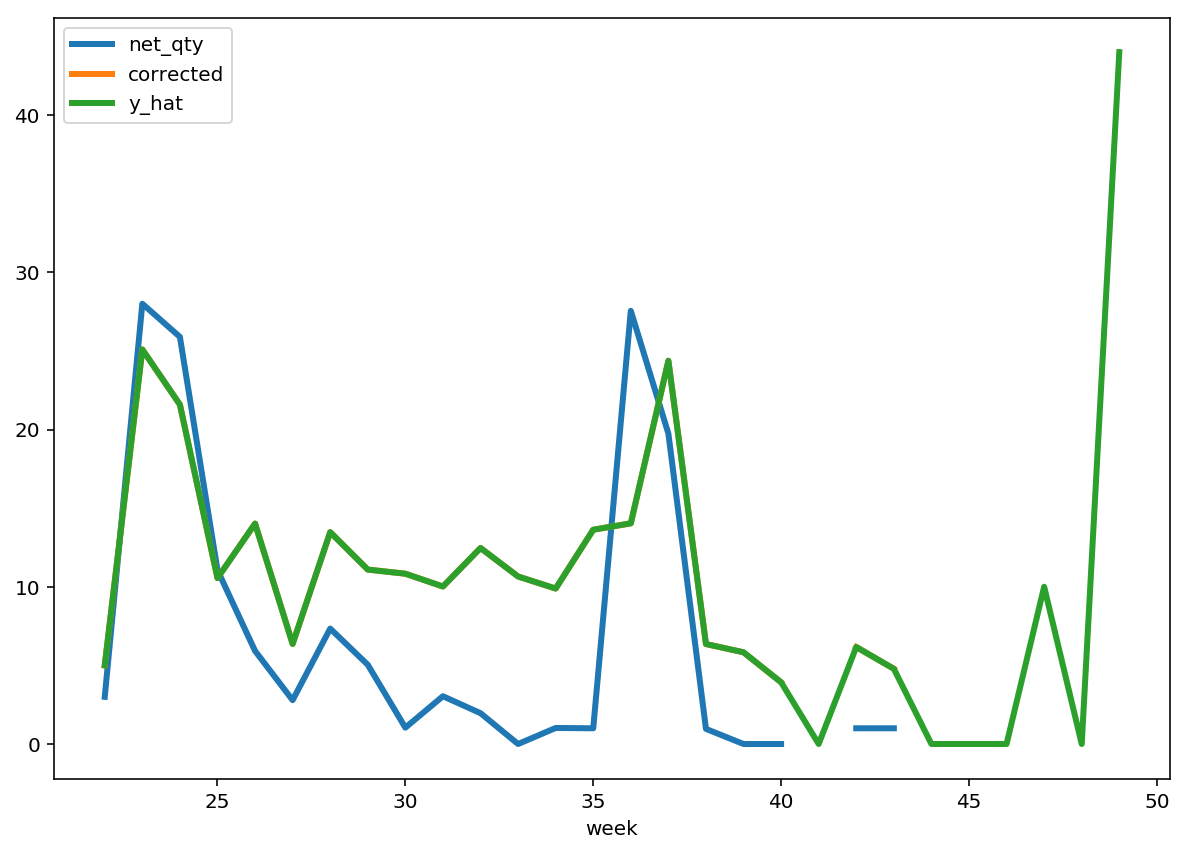

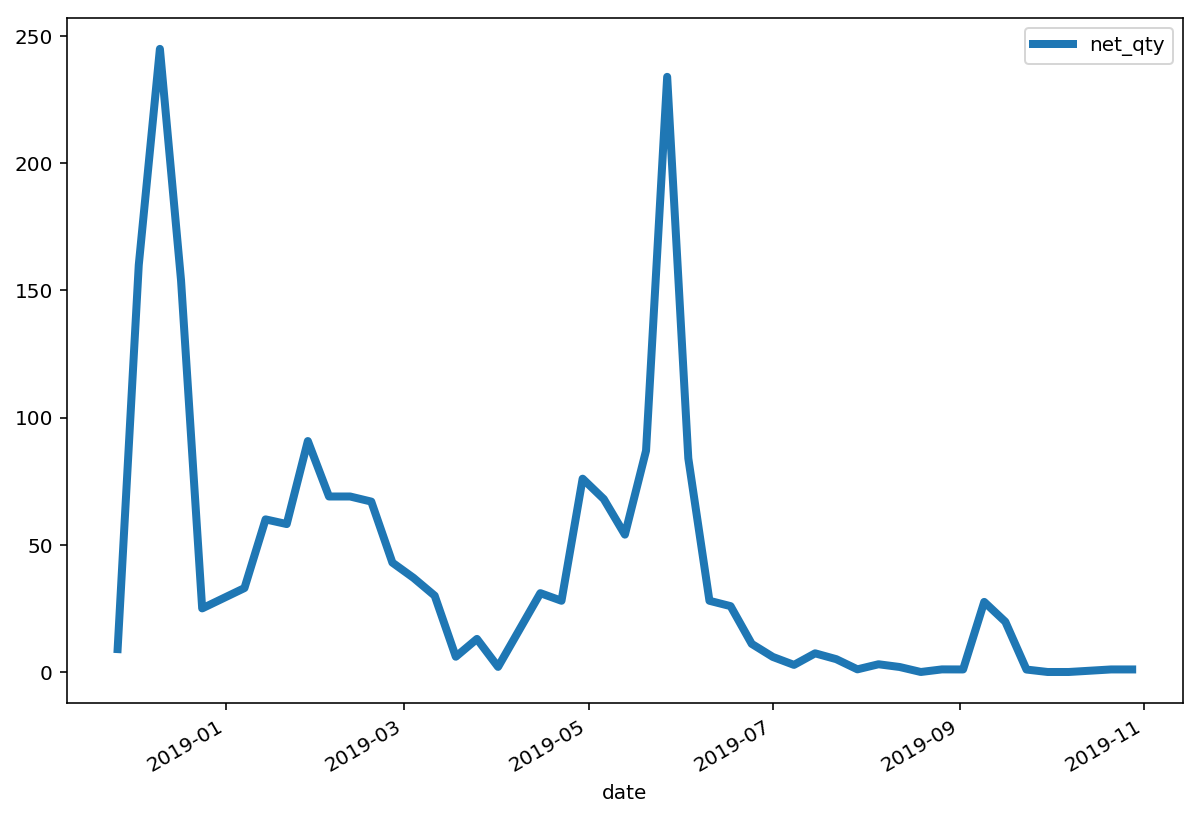

In [96]:
# EDA Plots

# ---- Plot -----
aoi = 'DV2848'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'corrected', 'y_hat']]
        

plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()

dat_a[['net_qty', 'corrected', 'y_hat']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index == a]
# dat0[dat0.article_number == aoi].iloc[1,]

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]
print('Actual actual: ', dat_aoi[dat_aoi.year == '2019'].net_qty.sum().round())

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# dat_aoi

In [97]:
preds_season.loc['EJ9682', 'notes'] = 'With less than 10 weeks of observed net_qty for this article, one of which was quite large, the model is misbehaving and making pathological inferences --- this forecast is not reliable.'
preds_season.loc['EE6999', 'notes'] = 'late drop, ~5400 units in less than 15 weeks in FW19 (so far), our forecast assumes a full FW20'
preds_season.loc['EE6038', 'notes'] = 'Somewhat of a downward trend this season (though not in the most recent weeks), with full season projected numbers around 2200 units; our buy rec climbs over 3K units, but far below eCom ~9K'
preds_season.loc['BD7611', 'notes'] = 'We have almost no non-clearance data on this article, and our (nonsensical?) forecast reflects this; actual net_qty of ~700 is same order of magnitude as eCom forecast -- which is good.'
preds_season.loc['M20607', 'notes'] = 'Our full season estimate for FW19 is just under 3000 units, so our FW20 forecast is on par with this; eCom sees much higher numbers in FW20'
preds_season.loc['F99786', 'notes'] = 'Quite modest FW19... big plans for FW20? Our model does not include marketing.'

preds_season.loc['DV0170', 'notes'] = 'We have almost no non-clearance data on this article, and our (nonsensical?) forecast reflects this; actual net_qty of ~700 is same order of magnitude as eCom forecast -- which is good.'

preds_season.loc['EF1053', 'notes'] = 'Modest (at best) FW19, but perhaps we are missing something; double-check this one.'

preds_season.loc['DV2848', 'notes'] = 'Lots of clearance transactions (out of scope) pushed our numbers down, but eCom RMA2 still looks quite high compared to fewer than 2K units in FW19.'
# preds_season.loc['G26523', 'notes'] =
# preds_season.loc['G26523', 'notes'] =
# preds_season.loc['G26523', 'notes'] =
# preds_season.loc['G26523', 'notes'] =
# preds_season.loc['G26523', 'notes'] =

In [77]:
# ---- Comments ----

#preds_season = preds_season.set_index('article_number')

preds_season['notes'] = '-'
preds_season.loc['EF0371', 'notes'] = 'Short FW19; our forecast assumes full FW20, with performance on par with observed FW19'
preds_season.loc['ED7679', 'notes'] = 'Typo? Article being replaced? Double check this one.'
preds_season.loc['DP2401', 'notes'] = 'Our forecast much higher--are there article changes/action we do not know about??'

preds_season.loc['DP2389', 'notes'] = 'Big decline expected by eCom for a reason unknown to DAA.'
preds_season.loc['DZ9414', 'notes'] = 'Huge discrepancy, probably a separate buyer strategy, but worth double-checking.'
preds_season.loc['DP2386', 'notes'] = 'eCom buy indicates a big decline is expected; presumably eCom has plans/changes not incorporated into our forecast'
preds_season.loc['DV1555', 'notes'] = 'eCom forecast ~3x DAA forecast. Negative sales trend over the last 10 months, but perhaps eCom has reason to expect such a large increase.'
preds_season.loc['DZ9415', 'notes'] = 'eCom forecast ~4x DAA forecast. eCom forecasts substantial increase. Noteworthy decreasing pattern so far this season, which admittedly not be significant. In any event, we assume there is justification for this projected increase, but double check.'
preds_season.loc['DZ9416', 'notes'] = 'eCom forecast ~4.5x DAA forecast. eCom forecasts substantial increase. We assume there is justification for this projected increase, but it seemed worth mentioning.'
preds_season.loc['EE7570', 'notes'] = 'Short FW19, so not a lot of data to work with. Our forecast assumes full FW20, with performance on par with observed FW19'
preds_season.loc['DZ9357', 'notes'] = 'Solid FW19 so far, with a positive trend, but eCom forecast is 4x DAA forecast. We do not have information suggest this increase, but perhaps eCom does.'
preds_season.loc['CM7492', 'notes'] = 'Decent sales so far, with hopefully a strong end to FW19 (as in FW18). Our forecast is 4x eCom forecast, so perhaps there is information we do not have about the rest of this season or the next.'
preds_season.loc['DZ9346', 'notes'] = 'Not many observed weeks to go on, but our forecast is much lower than eCom; if I recall there are strategies that explain intentional big overbuys on items like socks?'
preds_season.loc['DZ9356', 'notes'] = 'Not many observed weeks to go on, but our forecast is much lower than eCom; if I recall there are strategies that explain intentional big overbuys on items like socks?'
preds_season.loc['DP2419', 'notes'] = 'Seemingly solid FW19 so far; is there reason for eCom to expect a decline?'
preds_season.loc['DZ9355', 'notes'] = 'Big buy; if I recall there are strategies that explain intentional big overbuys on items like socks?'
preds_season.loc['F36641', 'notes'] = 'Only a handful of observed weeks of FW19, but forecast assumes FULL availability throughout FW20'
preds_season.loc['G27706', 'notes'] = 'While SS19 was strong, FW19 numbers are more modest, and the forecast reflects this.'

preds_season.loc['G26535', 'notes'] = 'We have very few observed weeks for this article, due to late season launch; so at this stage the forecast for this article is unreliable.'
preds_season.loc['EC6229', 'notes'] = 'We have very few observed weeks for this article, due to late season launch; so at this stage the forecast for this article is unreliable.'
preds_season.loc['G26487', 'notes'] = 'We have very few observed weeks for this article, due to late season launch; so at this stage the forecast for this article is unreliable.'
preds_season.loc['G26523', 'notes'] = 'We have very few observed weeks for this article, due to late season launch; so at this stage the forecast for this article is unreliable.'

preds_season.loc['EI7411', 'notes'] = 'We project corrected net_qty around 4000 units by end of season; eCom RMA1 number is 10% of that.'
preds_season.loc['DT3047', 'notes'] = 'We project corrected net_qty around 8000 units by end of season; eCom RMA1 number is ~15% of that.' 
preds_season.loc['ED8712', 'notes'] = 'We have very few observed weeks for this article; so at this stage the forecast for this article is unreliable.'
preds_season.loc['EF0118', 'notes'] = 'We project corrected net_qty around 2500 units by end of season; eCom RMA1 number is ~20% of that.' 
preds_season.loc['ED8620', 'notes'] = 'We have very few observed weeks for this article; so at this stage the forecast for this article is unreliable.'
preds_season.loc['FJ6350', 'notes'] = 'We project corrected net_qty around 3100 units by end of season; eCom RMA1 number is ~55% of that.' 
# preds_season.loc['EI5563', 'notes'] = 'We project corrected net_qty around 150 units by end of season; eCom RMA1 number is 30 times that.'
preds_season.loc['D95958', 'notes'] = 'We project corrected net_qty around 5000 units by end of season; eCom RMA1 number is 5 times that.'

In [ ]:
# preds_season.to_csv("FW20_forecasts.csv", sep=',', encoding='utf-8')
preds_season.to_excel("FW20_forecasts.xlsx")


# Results Summary

In [ ]:
fw20 = pd.read_excel('data/FW20_forecasts.xlsx') # adidas RMA2 -- 21 October


In [ ]:
fw20 = preds_season.copy()
len(fw20.index.unique())


In [ ]:
fw20.head()

In [ ]:
# adidas v rbk
from pandas import DataFrame, Series

fw20['brand'].value_counts()

In [ ]:
# Carrover coverage

fw20['rev'] = fw20.price * fw20.eCom_RMA1

In [ ]:
fw20.groupby('brand')['rev'].sum()

# Appendix

In [ ]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'DP2405'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
        
plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

In [ ]:


# article net_demand_qty
# y = a[['net_qty', 'week']].set_index('week')

# # article category-level weekly means; set_index() for joining
# x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == a.sports_cat_desc.unique()[0]].set_index('week')
# x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == a.rmh_cat_desc.unique()[0]].set_index('week')
# x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == a.gender_desc.unique()[0]].set_index('week')
# x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == a.age_group_desc.unique()[0]].set_index('week')
# x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == a.franchise.unique()[0]].set_index('week')
# x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == a.prod_grp_desc.unique()[0]].set_index('week')

# # design matrix (ensure 'week' alignment)
# yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
#       merge(x_rmh, left_index=True, right_index=True, how = 'outer').
#       merge(x_gndr, left_index=True, right_index=True, how = 'outer').
#       merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
#       merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
#       merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
#       drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
#            'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

# mod = sm.OLS(yX.net_qty, yX.drop('net_qty', axis = 1), missing='drop').fit()

# ret = pd.DataFrame(index = yX.index)

# # yX.reset_index()['week'][:5]
# # ret['week'] = yX.index

# # mod.predict(yX.drop('net_qty', axis = 1)).reset_index()[:5]
# ret['seas_preds'] = mod.predict(yX.drop('net_qty', axis = 1))

# ret

# y
# yX.head()
# yX.reset_index()
# mod.predict(yX.drop('net_qty', axis = 1))

In [ ]:
### ================= ARIMAX =================

pd.DataFrame(preds)

# Subset for troubleshooting
a = np.random.choice(seasonality_dat.article_number.unique(), size = 1, replace = False)
dat_a = seasonality_dat[seasonality_dat.article_number.isin(a)]


y = dat_a[['net_qty', 'week']].set_index('week')

x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == dat_a.sports_cat_desc.unique()[0]].set_index('week')
x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == dat_a.rmh_cat_desc.unique()[0]].set_index('week')
x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == dat_a.gender_desc.unique()[0]].set_index('week')
x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == dat_a.age_group_desc.unique()[0]].set_index('week')
x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == dat_a.franchise.unique()[0]].set_index('week')
x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == dat_a.prod_grp_desc.unique()[0]].set_index('week')

yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
      merge(x_rmh, left_index=True, right_index=True, how = 'outer').
      merge(x_gndr, left_index=True, right_index=True, how = 'outer').
      merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
      merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
      merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
      drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
           'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

yw = dat[dat.season == 'SS19'][['year', 'week']].drop_duplicates().sort_values(['year', 'week'])

yw.loc[:,'YEAR'] = [str(x)[:-2] for x in yw.year]
yw.loc[:,'WEEK'] = [str(x)[:-2] for x in yw.week]

yw.loc[:,'date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(yw.YEAR, yw.WEEK)]

yX = (pd.merge(yX, yw[['week', 'date']], left_index=True, right_on = 'week').
      drop('week', axis = 1).
      sort_values('date').
      set_index('date'))


reg = pd.merge(
    regress(dat_a),
    yw,
    left_index=True, right_on = 'week',
).set_index('date')

reg

# yX.index

# r = pd.date_range(start=yX.index.min(), end=yX.index.max(), freq = 'W')
# r

# yX #.reindex(r) #.fillna(0.0) # .rename_axis('dt').reset_index()

arimax = sm.tsa.statespace.SARIMAX(yX.net_qty,
                                   order = (1,0,1),
                                   seasonal_order = (0,0,0,0),
                                   exog = yX.drop('net_qty', axis = 1),
                                   enforce_stationarity=False, 
                                   enforce_invertibility=False,
                                   missing = 'drop').fit()

# arimax.summary()
preds = arimax.predict()
yX = pd.merge(
    yX, 
    pd.DataFrame(preds), right_index=True, left_index=True,
)

yX.columns
yX.iloc[:,7]

numerator = ((yX.net_qty - preds) ** 2).sum()
denominator = ((yX.net_qty - np.mean(yX.net_qty)) ** 2).sum()
1 - numerator/denominator



p = pd.DataFrame(index = yX.index)
p['net_qty'] = yX.net_qty
p['preds'] = arimax.predict()
p['original'] = yX.iloc[:,7]
p.plot()

### ================= End ARIMAXperiment =================

In [ ]:
# df = seasonality_dat[seasonality_dat.article_number == '218977']

# df = df.sort_values(['article_number', 'year', 'week'])

# # article net_demand_qty
# y = df[['net_qty', 'week']].set_index('week')

# # article category-level weekly means; set_index() for joining
# x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
# x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
# x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
# x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
# x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
# x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

# # design matrix (ensure 'week' alignment)
# yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
#       merge(x_rmh, left_index=True, right_index=True, how = 'outer').
#       merge(x_gndr, left_index=True, right_index=True, how = 'outer').
#       merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
#       merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
#       merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
#       drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
#            'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

# # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities

# y = yX.net_qty
# X = yX.drop('net_qty', axis = 1)
# X = sm.add_constant(X)

# mod = sm.OLS(y, X, missing='drop').fit()
# # print(df.article_number.unique(), round(mod.rsquared, 2))

# ret = pd.DataFrame(index = X.index)
# ret['seas_preds'] = mod.predict(X).round()
    
    
    

# X
# sm.OLS(y, X, missing='drop').fit().predict(X).round()

In [ ]:
df1 = pd.DataFrame({'article': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C'],
                     'week': [1, 2, 3, 1, 2, 3, 1, 2],
                     'cat-level': ['boy', 'boy', 'boy', 'girl', 'girl', 'girl', 'boy', 'boy']})
df2 = pd.DataFrame({'cat-level': ['boy', 'boy', 'boy', 'boy', 'girl', 'girl', 'girl', 'girl', 'girl'],
                     'week': [1, 2, 3, 4, 1, 2, 3, 4, 5]})

pd.merge(df1, df2, how = 'right').sort_values(['article', 'week'])

seasonality_dat = (
    pd.merge(seasonality_dat, seasonality_sport, how = 'left').
    merge(seasonality_rmh, how = 'left').
    merge(seasonality_gndr, how = 'left').
    merge(seasonality_agegrp, how = 'left').
    merge(seasonality_prdgrp, how = 'left').
    sort_values(['article_number', 'year', 'week']))
#  drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))


def regress(df):
    # function for regressing article net_qty on cat-level means (seasonality)
    
    df = df.copy()

    mod = sm.OLS(df.net_qty, df[['sport_weekly_mean', 'rmh_weekly_mean', 'gender_weekly_mean', 'age_weekly_mean', 'prd_grp_weekly_mean']]).fit()

    # print(df.article_number.unique(), round(mod.rsquared, 2))
    print(df.article_number.unique()[0])
    
    mods[df.article_number.unique()[0]] = mod

    ret = pd.DataFrame()
    ret['article_number'] = df.article_number
    ret['seas_preds'] = mod.predict()

    return ret

In [ ]:
# kids_jackets = pd.read_excel('data/jackets_kids.xlsx', sheet_name='FW18 art list')

dat_kj = dat0[(dat0.article_number.isin(kids_jackets['Article Number'])) & (dat0.season == 'FW18')]


In [ ]:
# -- NA check --
# seasonality_dat[pd.isnull(seasonality_dat).any(axis=1)]

In [ ]:
# seasonality_dat = seasonality_dat[seasonality_dat.season_net_qty > 100].sort_values(['article_number', 'year', 'week'])
                                  # & (seasonality_dat.season.isin(['SS19', 'SS17', 'SS18']))] # CHANGE THIS FOR DELIVERY

# ref_dat = ref_dat0.copy()[['article_no', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() 

# Combine category-level means -- and -- transactions
# seasonality_dat = pd.merge(seasonality_dat, ref_dat, 
#     left_on='article_number', right_on='article_no', 
#     how = 'left'
#     ).sort_values(['article_number', 'year', 'week'])



In [ ]:
# EDA Plots

preds_season = preds_season.reset_index()

# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'DV1549'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
        
plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# dat_aoi

In [ ]:
# # --- adi forecasts ---
# WE_eCom = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
#                        usecols = ['Article Number', 'WE eCom', 'eCom Range'])
# WE_eCom = WE_eCom[WE_eCom['eCom Range'] == 'YES'].drop('eCom Range', axis = 1)

# WE_eCom['WE eCom'] = [int(x.replace(",", "")) for x in WE_eCom['WE eCom']]

# # --- Reebok forecasts ---
# rma1_rbk = (pd.read_csv('data/article_range_rma1_reebok_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
#                        usecols = ['Article_number', 'Total Marketing Forecast']).
#             rename(columns = {'Article_number': 'Article Number', 'Total Marketing Forecast': 'WE eCom'}))

# WE_eCom = pd.concat([WE_eCom, rma1_rbk])

In [ ]:
# # DAVID code

# # Function Definitions

# class parameters():
#     def __init__(self, param_array):
#         self.alpha = param_array[0]
#         self.beta = param_array[1]
#         self.omega = param_array[2] / (1-self.beta) # one way to choose that is omega/(1-beta) = uncoMnditional mean
#         self.sigma = param_array[3]
#         self.f0 = param_array[4] # one way to choose is unconditional mean

# def loglik(x, y, f, sigma):
#     ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2
#     return ll

# def score_compute(x, y, f, sigma):
#     return (y - x*f)/sigma

# def score_compute_2(x, y, f, sigma=None):
#     return(y - x*f) # ** The 'type = 2' modification **

# def filterGAS(p, x, y, score_fun):
#     score0 = score_fun(x[0,:], y[0,:],p.f0, p.sigma)
#     f = np.zeros((len(y),1))
#     f[0,:] = p.f0
#     for t in range(1,len(y)):
#         scoret = score_fun(x[t-1,:], y[t-1,:], f[t-1,:], p.sigma)
#         f[t,:] = p.omega + p.alpha*scoret + p.beta*f[t-1,:]
#     return f


# def loglikest(params, x, y, score_fun):
#     p = parameters(params)
#     f = filterGAS(p, x, y, score_fun)
#     ll = np.zeros((len(y), 1))
#     m = len(y)
#     for t in range(0, len(y)):
#         ll[t,:] = loglik(x[t,:], y[t,:], f[t,:], p.sigma)
#     loglik_res = -(np.sum(ll))/m
#     return loglik_res


# def GAS_optimize(x, y, score_fun, marker_str):
#     return scipy.optimize.minimize(
#        loglikest,                              # function to minimize (log likelihood y|x,theta)
#        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
#        args=(x, y, score_fun),
#        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12}, # TODO pass as parameter or create config file
#        method='L-BFGS-B',
#        bounds=((0,  None),             # alpha
#                (-1, 1),                # beta
#                (0.001, np.mean(y)*2),  # omega
#                (0.001, None),          # sigma
#                (0.001, np.mean(y)*2)   # f
#               )
#        )



# def GAS_est(df):
#     """ <High level description of function>
#     Parameters
#     ----------
#     df : pandas DataFrame
#        <Description>
#     Returns
#     -------
#     ret: pandas DataFrame
#        <Description>
#     Raises
#     ------
#     (List and description of specific errors generated and thrown based on intenal function requirements)
#     OtherError when an other error
#     """
#     y = df.net_qty.values.reshape(-1,1)          # observed demand (response)
#     x = df.buy_availability.values.reshape(-1,1)   # buy_availability (explanatory)
    
#     ret = pd.DataFrame()
#     ret[['year','week']] = df[['year','week']]
    
#     score_fun = score_compute
#     marker_str = 'One'
    
#     opt_result = GAS_optimize(x, y, score_fun, marker_str)
    
#     if opt_result.success == False:
#         score_fun= score_compute_2
#         marker_str = 'Two'
#         opt_result = GAS_optimize(x, y, score_fun, marker_str)
        
#     x1par = parameters(opt_result.x)
#     GAS = filterGAS(x1par, x, y, score_fun)
    
#     ret['GAS_est'] = GAS
#     ret['Convergence'] = [opt_result.success] * len(y)
#     ret['Convg type'] = [marker_str] * len(y)
    
#     return ret

In [ ]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'D95958'
a = aoi
dat_a[['net_qty', 'corrected', 'y_hat']].apply(np.sum).round()

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'corrected', 'y_hat']]
        
plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()


preds_season.reset_index()[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# dat_aoi

In [ ]:
# April articles

aas = ['DV1549', 'EE1152', 'DV1508', 'ED6024', 'CY4574', 'ED9384', 'BK7345', 'DV2400', 'DH5798']

# aoi = 'DV1549'
# a = aoi

preds_aa = (preds[preds.article_number.isin(aas)][['article_number', 'week', 'net_qty', 'GAS_est', 'seas_preds', 'y_hat']].
            sort_values(['article_number', 'week']).
            set_index('week')).round()
        

preds_aa[preds_aa.article_number == 'DV1549']

pred_aggs_aa = preds_aa.groupby('article_number')[['net_qty', 'GAS_est', 'seas_preds', 'y_hat']].apply(sum).round()



for c in pred_aggs_aa.columns:
    if type(pred_aggs_aa[c][1]) == np.float64:
        pred_aggs_aa[c] = pred_aggs_aa[c].fillna(0).astype(int)

pred_aggs_aa[~np.isnan(pred_aggs_aa.GAS_est)].loc[aas[i-1], 'y_hat'].sum()





fig = plt.figure(figsize=(25,32)); # width, height
fig.subplots_adjust(hspace=0.5, wspace=0.2); # vertical spacing, horizontal spacing
for i in range(1, 10):
    ax = fig.add_subplot(5, 2, i, )
    preds_ax = preds_aa[preds_aa.article_number == aas[i-1]]
    ax.plot(preds_ax.index, preds_ax['net_qty'], linewidth=4.5, label = 'Observed net_qty')
    ax.plot(preds_ax.index, preds_ax['y_hat'], linewidth=4.5, label = 'Model net_qty estimate')
    ax.set_title('Article: ' + aas[i-1] + 
                 ' \n net_qty STD: ' + str(pred_aggs_aa.loc[aas[i-1], 'net_qty']) + 
                 ' \n Full availability estimate STD: ' + str(preds_aa[(~np.isnan(preds_aa.GAS_est)) & (preds_aa.article_number == aas[i-1])].y_hat.sum().astype(int)) +
                 ' \n FW19 full season estimate: ' + str(pred_aggs_aa.loc[aas[i-1], 'y_hat']), 
                 fontsize=16)
    ax.legend()

fig.savefig('aa_fig.png')    

pass;



preds_aa[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index.isin(aas)]

dat_aa = dat0[dat0.article_number.isin(aas)].copy()

dat_aa = pd.merge(
    pd.DataFrame(dat_aa.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aa[['year', 'week']].drop_duplicates()
)

dat_aa.year = [str(x) for x in dat_aa.year]
dat_aa.week = [str(x) for x in dat_aa.week]
dat_aa['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aa.year, dat_aa.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aa[['date', 'net_qty']].set_index('date').plot(linewidth = 4)